# Topic Modelling and Analysis

## Import Packages and Defining Helper Functions

In [143]:
# import required packages
#warnings :)
import warnings
warnings.filterwarnings('ignore')

# for df purpose
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
tqdm.pandas()

# for text processing
import nltk
import re
import string
from autocorrect import Speller
import malaya

# for topic modelling
import gensim as gensim
from gensim import matutils, models, corpora
import scipy.sparse
import pyLDAvis.gensim

# for graph plotting / visualisation
import matplotlib.pyplot as plt
import matplotlib.dates
import seaborn as sns
%matplotlib inline
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.feature_extraction.text import CountVectorizer

#for storing intermediate results
import pickle

# for notebook function
from IPython.display import display, clear_output
import json
import time

In [3]:
def print_bold(text):
    text_bold = '\x1b[1;30;47m'+text+ '\x1b[0m'
    print(text_bold)
def glance(x,n=5):
    try:
        iterator = iter(x)
    except:
        print(x)
        return
    else:
        if type(x) == str or len(str(x)) <= 50:
            print(x)
            return
        if type(x) == dict:
            iterator = x.items()
        i = 0
        for ele in iterator:
            if i >= n:
                break
            glance(ele,n)
            i += 1

## Read Data and perform secondary cleaning

In [6]:
df = pd.read_pickle('pickles/df_analyse')
df

,Platform,comment,date,page_name,reaction,search_term,share,title,user_id,user_name,tokens,count,year,month,lang,entities,pos,stem,lang_group
0,Facebook,8,2015-01-30,KEMENTERIAN KESIHATAN MALAYSIA,364,Blood Donation,0,Schedule & Location of Blood Donation Campaign...,-,-,"[schedule, location, of, blood, donation, camp...",9,2015,1,eng,"[(Schedule, location), (&, location), (Locatio...","[(Schedule, PROPN), (&, SYM), (Location, PROPN...","[schedule, location, of, blood, donation, camp...",eng
1,Facebook,1,2015-12-11,KEMENTERIAN KESIHATAN MALAYSIA,391,Blood Donation,0,"""Donating blood is not a right. It's a privile...",-,-,"[donating, blood, is, not, a, right, it, s, a,...",10,2015,12,eng,"[(""Donating, OTHER), (blood, OTHER), (is, OTHE...","[(""Donating, PROPN), (blood, PROPN), (is, PROP...","[donating, blood, is, not, a, right, it, s, a,...",eng
2,Facebook,0,2015-07-24,KEMENTERIAN KESIHATAN MALAYSIA,0,Blood Donation,0,Did you know where your donated blood goes?,-,-,"[did, you, know, where, your, donated, blood, ...",8,2015,7,eng,"[(Did, OTHER), (you, OTHER), (know, OTHER), (w...","[(Did, PROPN), (you, PRON), (know, VERB), (whe...","[did, you, know, where, your, donated, blood, go]",eng
3,Facebook,6,2015-11-16,KEMENTERIAN KESIHATAN MALAYSIA,142,Blood Donation,0,“You’re Somebody’s Type” Blood Donation Drive ...,-,-,"[you, re, somebody, s, type, blood, donation, ...",23,2015,11,eng,"[(""You're, OTHER), (Somebody's, OTHER), (Type""...","[(""You're, PROPN), (Somebody's, PROPN), (Type""...","[you, re, somebody, s, type, blood, donation, ...",eng
4,Facebook,0,2015-04-03,KEMENTERIAN KESIHATAN MALAYSIA,0,Blood Donation,0,…how to use mosquito fogging guns and donate b...,-,-,"[to, use, mosquito, fogging, guns, and, donate...",36,2015,4,eng,"[(...how, OTHER), (to, OTHER), (use, OTHER), (...","[(...how, PUNCT), (to, ADP), (use, VERB), (mos...","[to, use, mosquito, fogging, gun, and, donate,...",eng
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4288,Twitter,0,2019-04-03,-,0,-,1,3/4/2019 \nProgram Derma Darah MAKSAK Malaysia...,@zaidalifah,zaidalifah aisheteru,"[program, derma, darah, maksak, malaysia, tahu...",33,2019,4,ind,"[(3/4/2019, OTHER), (Program, OTHER), (Derma, ...","[(3/4/2019, NUM), (Program, NOUN), (Derma, PRO...","[program, derma, darah, maks, malaysia, tahun,...",malay
4289,Twitter,0,2019-04-02,-,0,-,0,Terima kasih kepada Institut Latihan Kementeri...,@BloodBankHUS,BloodBankHUS,"[terima, kasih, kepada, institut, latihan, kem...",29,2019,4,malay,"[(Terima, OTHER), (kasih, OTHER), (kepada, OTH...","[(Terima, VERB), (kasih, NOUN), (kepada, ADP),...","[terima, kasih, kepada, institut, latih, mente...",malay
4290,Twitter,0,2019-03-31,-,9,-,1,PROGRAM DERMA DARAH ANJURAN KULIYYAH ICT IIUM ...,@RTM_Malaysia,RTM Malaysia,"[program, derma, darah, anjuran, kuliyyah, ict...",27,2019,3,malay,"[(PROGRAM, OTHER), (DERMA, location), (DARAH, ...","[(PROGRAM, NOUN), (DERMA, NOUN), (DARAH, NOUN)...","[program, derma, darah, anjuran, kuliyyah, ict...",malay
4291,Twitter,1,2019-04-04,-,0,-,2,Jadual Kempen Derma Darah\n4 April 2019 (Khami...,@RTM_Malaysia,RTM Malaysia,"[jadual, kempen, derma, darah, april, khamis, ...",30,2019,4,malay,"[(Jadual, event), (Kempen, event), (Derma, eve...","[(Jadual, NOUN), (Kempen, PROPN), (Derma, PROP...","[jadual, kempen, derma, darah, april, khamis, ...",malay


In [8]:
# Separate df into English and Malay
df_eng = df[df['lang_group'] == 'eng']
df_malay = df[df['lang_group'] == 'malay']
print('English Posts: %s' % len(df_eng))
print('Malay Posts: %s' % len(df_malay))

English Posts: 854
Malay Posts: 3327


### Removing Stop Words

#### Malay

In [16]:
word_counts = {}
def count_words(tokens):
    for t in tokens:
        if t not in word_counts:
            word_counts[t] = 0
        word_counts[t] += 1
df_malay['stem'].progress_apply(count_words)
count_df = pd.DataFrame({'count':word_counts}).sort_values('count',ascending=False)
print(count_df.head(20)['count'])


darah            5154
derma            4574
di               1662
yang             1416
kempen           1408
dan              1114
untuk            1018
ini               917
jomdermadarah     809
anda              746
jom               630
kami              628
malaysia          627
hari              585
jadual            551
hospital          508
pada              496
kepada            495
program           447
akan              438
Name: count, dtype: int64


In [42]:
def load_ms_stopwords():
    try:
        ms_stopwords = json.load(open('pickles/ms_stopwords.json','rb'))
        print('stopwords found: %s' % len(ms_stopwords))
        return ms_stopwords
    except:
        print('stopwords not found')
        json.dump([],open('pickles/ms_stopwords.json','a'))
        return []
def add_ms_stopwords(new_list):
    ms_stopwords = load_ms_stopwords()
    for t in new_list:
        if t not in ms_stopwords:
            ms_stopwords.append(t)
    json.dump(ms_stopwords,open('pickles/ms_stopwords.json','w'))
    return load_ms_stopwords()
def remove_stopwords(series):
    ms_stopwords = load_ms_stopwords()
    return series.apply(lambda x: [t for t in x if t not in ms_stopwords])

In [45]:
add_ms_stopwords(['ke','bagi'])
df_malay['stem'] = remove_stopwords(df_malay['stem'])
word_counts = {}
df_malay['stem'].progress_apply(count_words)
count_df = pd.DataFrame({'count':word_counts}).sort_values('count',ascending=False)
print(count_df.head(20)['count'])

stopwords found: 16
stopwords found: 18
stopwords found: 18



kempen           1408
jomdermadarah     809
jom               630
malaysia          627
hari              585
jadual            551
hospital          508
program           447
terima            393
perlu             360
ahad              348
selamat           347
kasih             324
masa              318
blood             317
tidak             314
bulan             310
bantu             309
aeon              302
sama              284
Name: count, dtype: int64


#### English

In [51]:
stopset = set(nltk.corpus.stopwords.words('english'))
df_eng['stem'] = df_eng['stem'].apply(lambda x: [t for t in x if t not in stopset])
word_counts = {}
df_eng['stem'].progress_apply(count_words)
count_df = pd.DataFrame({'count':word_counts}).sort_values('count',ascending=False)
print(count_df.head(20)['count'])


blood            1112
donation          624
campaign          232
malaysia          204
life              188
donate            178
jomdermadarah     143
donor             134
drive             117
save              113
u                 107
http              100
come               95
please             91
new                78
hospital           77
need               74
time               73
thank              72
day                70
Name: count, dtype: int64


In [53]:
stopset.update(['blood','donation','u','http'])
df_eng['stem'] = df_eng['stem'].apply(lambda x: [t for t in x if t not in stopset])
word_counts = {}
df_eng['stem'].progress_apply(count_words)
count_df = pd.DataFrame({'count':word_counts}).sort_values('count',ascending=False)
print(count_df.head(20)['count'])


campaign         232
malaysia         204
life             188
donate           178
jomdermadarah    143
donor            134
drive            117
save             113
come              95
please            91
new               78
hospital          77
need              74
time              73
thank             72
day               70
today             63
photo             60
mall              60
may               59
Name: count, dtype: int64


## Topic Modelling

### Malay Posts

In [68]:
cv_malay = CountVectorizer()  # remove stop words from the build-in CountVectorizer
data_cv = cv_malay.fit_transform(df_malay['stem'].apply(lambda x: ' '.join(x)))
data_dtm = pd.DataFrame(data_cv.toarray(),columns=cv_malay.get_feature_names())
data_dtm.index = df_malay.index
data_dtm

,aa,aaliya,aamiin,ab,abaraba,abcsmdadv,abd,abdul,abdull,abdullah,...,zeal,zero,zhen,zika,zombi,zon,zonhuluselangor,zuhair,zulkifli,zz
15,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
22,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
24,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
25,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4288,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4289,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4290,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4291,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [77]:
tdm = data_dtm.transpose()
sparse_counts = scipy.sparse.csr_matrix(tdm)
corpus_malay = matutils.Sparse2Corpus(sparse_counts)
dictionary_malay = corpora.Dictionary(df_malay['stem'])

In [81]:
# base model
lda_malay = models.LdaModel(corpus=corpus_malay, id2word=dictionary_malay, num_topics=3, passes=50)
lda_malay.print_topics()
coherence_score = models.CoherenceModel(model=lda_malay, texts=df_malay['stem'], dictionary=dictionary_malay, coherence='c_v').get_coherence()
coherence_score

0.77348274182089

#### Hyperparameter Tuning

In [131]:
def grid_search_tuning(corpus, dictionary,topics_range=None, alpha=None, beta=None, random_state=100, texts=df_malay['stem']):
    
    # supporting function
    def compute_coherence_values(corpus, dictionary, k, a, b, random_state=100):

        lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                               id2word=dictionary,
                                               num_topics=k, 
                                               random_state=random_state,
                                               chunksize=100,
                                               passes=10,
                                               alpha=a,
                                               eta=b,
                                              )

        coherence_model_lda = models.CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')

        return coherence_model_lda.get_coherence()

    # Topics range
    if topics_range is None:
        min_topics = 3
        max_topics = 5
        step_size = 1
        topics_range = range(min_topics, max_topics, step_size)
        print('Using default topics range: ',topics_range)
    else:
        print('topics_range: ',topics_range)

    # Alpha parameter
    if alpha is None:
        alpha = list(np.arange(0.1, 1, 0.1))
        alpha.append('symmetric')
        alpha.append('asymmetric')
        print('Using default alpha list: ',alpha)
    else:
        print('alpha: ',alpha)

    # Beta parameter
    if beta is None:
        beta = list(np.arange(0.1, 1, 0.1))
        beta.append('symmetric')
        print('Using default beta list: ',beta)
    else:
        print('beta: ',beta)

    model_results = {
        'Topics': [],
        'Alpha': [],
        'Beta': [],
        'Coherence': []
    }

    # Can take a long time to run
    if 1 == 1:
        pbar = tqdm(total=len(topics_range)*len(alpha)*len(beta))
        # iterate through number of topics
        for k in topics_range:
            # iterate through alpha values
            for a in alpha:
                # iterare through beta values
                for b in beta:
                    # get the coherence score for the given parameters
                    cv = compute_coherence_values(corpus=corpus, dictionary=dictionary, k=k, a=a, b=b, random_state=random_state)
                    # Save the model results
                    model_results['Topics'].append(k)
                    model_results['Alpha'].append(a)
                    model_results['Beta'].append(b)
                    model_results['Coherence'].append(cv)

                    pbar.update(1)
#         pd.DataFrame(model_results).to_csv('outputs/lda_tuning_results.csv', index=False)
        pbar.close()
    return model_results

In [107]:
model_results = pd.DataFrame(grid_search_tuning(corpus_malay,dictionary_malay,[3,4]))
model_results.sample(5)

topics_range:  [3, 4]
Using default alpha list:  [0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6, 0.7000000000000001, 0.8, 0.9, 'symmetric', 'asymmetric']
Using default beta list:  [0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6, 0.7000000000000001, 0.8, 0.9, 'symmetric']


,Topics,Alpha,Beta,Coherence
35,3,0.4,0.6,0.751372
47,3,0.5,0.8,0.753016
214,4,asymmetric,0.5,0.769936
64,3,0.7,0.5,0.747335
144,4,0.4,0.5,0.761311


In [108]:
top_models = model_results.sort_values('Coherence',ascending=False).head(5)
# tuning_results['Group'] = tuning_results[['Alpha','Beta']].apply(lambda x: ', '.join(x.astype(str)), axis=1)
# sns.lineplot(x='Topics', y='Coherence', data=tuning_results, hue='Group')
top_models

,Topics,Alpha,Beta,Coherence
210,4,asymmetric,0.1,0.777114
168,4,0.6,0.9,0.776913
196,4,0.9,0.7,0.774188
100,3,asymmetric,0.1,0.773683
167,4,0.6,0.8,0.773336


In [109]:
# Best Performing Topic
[num_topics, alpha, eta] = top_models.iloc[0][['Topics','Alpha','Beta']]

lda_malay = models.LdaModel(corpus=corpus_malay, id2word=dictionary_malay, num_topics=num_topics, passes=100, alpha=alpha, eta=eta)
lda_malay.save('models/lda_malay.gensim')
lda_malay.print_topics()

[(0,
  '0.042*"selagi" + 0.023*"pelajarp" + 0.020*"medan" + 0.016*"maritim" + 0.014*"meriahkn" + 0.014*"keduadua" + 0.014*"kecik" + 0.013*"kritikal" + 0.009*"buddhism" + 0.009*"wwfacebookcompusatdarahmelalangembara-iania"'),
 (1,
  '0.035*"netizen" + 0.024*"abu" + 0.019*"ncd" + 0.015*"month" + 0.015*"alhamdulillah" + 0.014*"menggunakn" + 0.013*"lepaskn" + 0.013*"black" + 0.011*"austria" + 0.009*"selagi"'),
 (2,
  '0.014*"sinaronline" + 0.011*"mati" + 0.010*"ceramah" + 0.010*"mantan" + 0.010*"cm" + 0.008*"nothing" + 0.007*"mejayakan" + 0.007*"lecturers" + 0.007*"facebookcompermalelkh" + 0.007*"itu"'),
 (3,
  '0.029*"tabung" + 0.020*"ootd" + 0.015*"nikmat" + 0.015*"dang" + 0.014*"mallharap" + 0.014*"pendermadarahkonsisten" + 0.014*"imago" + 0.013*"antara" + 0.013*"meriahkn" + 0.013*"elken"')]

In [110]:
df_malay['topic'] = [max(ele, key = lambda x:x[1])[0] for ele in lda_malay[corpus_malay]]
for i in range(0,4,1):
    print('='*20)
    print('topic: ', i)
    for title in df_malay[df_malay['topic'] == i].sample(10)['title']:
        print('-'*10)
        print(title)

topic:  0
----------
Terima ksh kepada yg menderma hr ni... 👍🏻
----------
Kriteria untuk menderma darah. #DermaDarah #DarahAndaPenyelamatNyawa
----------
Jadual Kempen Derma Darah 1 Mac 2017 (Rabu) #jomdermadarah
----------
Penang...:)
----------
Derma Darah Satria (H. Kulim) Sambutan sangat menggalakkan. Sebanyak 107 pint darah berjaya dikutip setakat ini.
----------
Salam sejahtera.. Jom derma darah minggu ini.. Jadual Kempen Derma Darah di kawasan Pulau Pinang dan Seberang Perai pada tarikh 27, 28 & 30 Julai 2019 (Sabtu, Ahad & Selasa) adalah seperti berikut: #jomdermadarah #dermadarahpenang
----------
Miri : )
----------
Penang : )
----------
…Jom ,kita boleh pi Hospital untuk derma darah penuhi tabung darah. semoga pihak hospital ada darah yang cukup .Orang ramai juga dijemput datang ke Aeon Jusco Mall ALMA,BM.menyertai Kempen derma darah pada Ahad ni 29-10-2017 ,pukul 10 hingga 2 pm. Takziah kepada keluarga mangsa yang terlibat.... Yang cedera,semoga bersemangat!bertabah!cepat se

Understanding Topics
* Topic 0 - Informal Advertisement of Blood Donation Campaign
* Topic 1 - Information on Blood Supply Shortage and Existing Blood Donation Programs
* Topic 2 - Educating Blood Donors on Related Information
* Topic 3 - Formal Advertisement of Blood Donation Campaigns

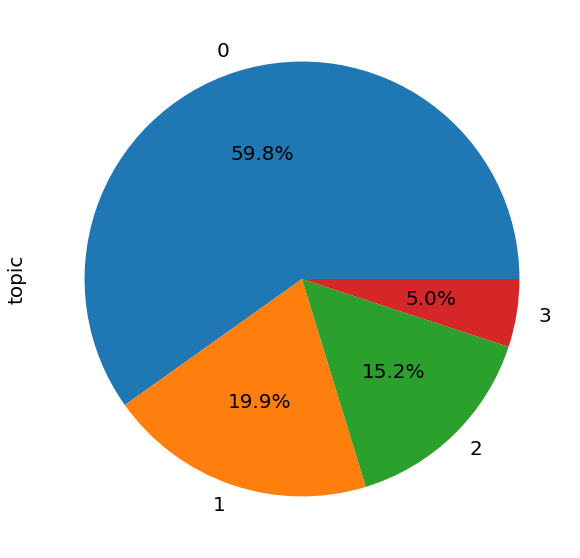

In [160]:
plt.rcParams["font.size"] = "20"
df_malay['topic'].value_counts().plot.pie(figsize=(10,10),autopct='%1.1f%%')

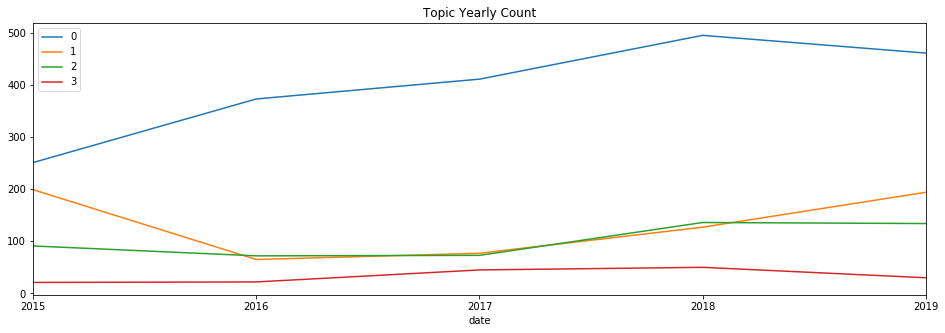

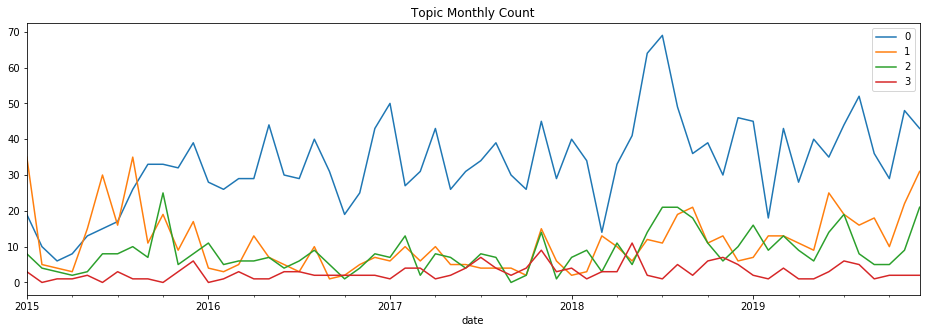

In [152]:
df_topic_year = pd.DataFrame()
df_topic_month = pd.DataFrame()
for topic in range(0,4,1):
    temp_df = df_malay[df_malay['topic'] == topic]
    temp_series = temp_df['topic']
    temp_series.index = temp_df['date']
    df_topic_year[topic] = temp_series.resample('Y').count()
    df_topic_month[topic] = temp_series.resample('M').count()
df_topic_year.plot(figsize=(16,5), title='Topic Yearly Count')
ax = df_topic_month.plot(figsize=(16,5), title='Topic Monthly Count')
# ax.xaxis.set_major_locator(matplotlib.dates.YearLocator())
# ax.xaxis.set_minor_locator(matplotlib.dates.MonthLocator((1,4,7,10)))
# ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter("\n%Y"))
# ax.xaxis.set_minor_formatter(matplotlib.dates.DateFormatter("%b"))

### English Posts

In [125]:
cv_eng = CountVectorizer()  # remove stop words from the build-in CountVectorizer
data_cv = cv_eng.fit_transform(df_eng['stem'].apply(lambda x: ' '.join(x)))
data_dtm = pd.DataFrame(data_cv.toarray(),columns=cv_eng.get_feature_names())
data_dtm.index = df_eng.index
data_dtm

,ab,abang,abdul,abdullah,able,aboutgoogle,absolutely,abt,abyjamilday,accelerated,...,获赠一朵手工制作的康乃馨花,蒲种普门善导寺,詳情詢問,謝謝,醫院,電話,马來西亚献血者协会,马大醫院,马来西亚捐血运动,종대
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4029,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4076,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4078,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4105,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [127]:
# remove Chinese Characters
df_eng['stem'] = df_eng['stem'].apply(lambda x: [t for t in x if re.match('[a-zA-Z]', t)])
cv_eng = CountVectorizer()  # remove stop words from the build-in CountVectorizer
data_cv = cv_eng.fit_transform(df_eng['stem'].apply(lambda x: ' '.join(x)))
data_dtm = pd.DataFrame(data_cv.toarray(),columns=cv_eng.get_feature_names())
data_dtm.index = df_eng.index
data_dtm

,ab,abang,abdul,abdullah,able,aboutgoogle,absolutely,abt,abyjamilday,accelerated,...,youthank,youtubecom,youtubepawan,yr,yu,zero,zhi,zhiyi,zone,zurich
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4029,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4076,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4078,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4105,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [128]:
tdm = data_dtm.transpose()
sparse_counts = scipy.sparse.csr_matrix(tdm)
corpus_eng = matutils.Sparse2Corpus(sparse_counts)
dictionary_eng = corpora.Dictionary(df_eng['stem'])

In [129]:
# base model
lda_eng = models.LdaModel(corpus=corpus_eng, id2word=dictionary_eng, num_topics=3, passes=50)
lda_eng.print_topics()
coherence_score = models.CoherenceModel(model=lda_eng, texts=df_eng['stem'], dictionary=dictionary_eng, coherence='c_v').get_coherence()
coherence_score

0.7824570620121407

In [132]:
model_results = pd.DataFrame(grid_search_tuning(corpus_eng,dictionary_eng,[3,4],texts=df_eng['stem']))
model_results.sample(5)

topics_range:  [3, 4]
Using default alpha list:  [0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6, 0.7000000000000001, 0.8, 0.9, 'symmetric', 'asymmetric']
Using default beta list:  [0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6, 0.7000000000000001, 0.8, 0.9, 'symmetric']


,Topics,Alpha,Beta,Coherence
58,3,0.6,0.9,0.790685
143,4,0.4,0.4,0.766110
112,4,0.1,0.3,0.772666
125,4,0.2,0.6,0.767790
203,4,symmetric,0.4,0.769893


In [133]:
top_models = model_results.sort_values('Coherence',ascending=False).head(5)
# tuning_results['Group'] = tuning_results[['Alpha','Beta']].apply(lambda x: ', '.join(x.astype(str)), axis=1)
# sns.lineplot(x='Topics', y='Coherence', data=tuning_results, hue='Group')
top_models

,Topics,Alpha,Beta,Coherence
101,3,asymmetric,0.2,0.804082
119,4,0.1,symmetric,0.799645
84,3,0.9,0.5,0.798521
107,3,asymmetric,0.8,0.797920
208,4,symmetric,0.9,0.794839


In [134]:
# Best Performing Topic
[num_topics, alpha, eta] = top_models.iloc[0][['Topics','Alpha','Beta']]

lda_eng = models.LdaModel(corpus=corpus_eng, id2word=dictionary_eng, num_topics=num_topics, passes=100, alpha=alpha, eta=eta)
lda_eng.save('models/lda_eng.gensim')
lda_eng.print_topics()

[(0,
  '0.025*"soul" + 0.023*"happy" + 0.019*"lasting" + 0.017*"technological" + 0.015*"icu" + 0.014*"chain" + 0.013*"based" + 0.011*"harun" + 0.010*"organize" + 0.009*"selfless"'),
 (1,
  '0.045*"sin" + 0.025*"kuchingsarawak" + 0.023*"lasting" + 0.022*"growth" + 0.020*"needing" + 0.019*"dengue" + 0.011*"jci" + 0.007*"card" + 0.006*"setapak" + 0.006*"refugee"'),
 (2,
  '0.020*"participate" + 0.018*"available" + 0.016*"visit" + 0.013*"kwan" + 0.011*"lasting" + 0.010*"chain" + 0.009*"sin" + 0.007*"mount" + 0.007*"standard" + 0.006*"towards"')]

In [137]:
df_eng['topic'] = [max(ele, key = lambda x:x[1])[0] for ele in lda_eng[corpus_eng]]
for i in range(0,3,1):
    print('\n')
    print('='*20)
    print_bold('topic: %s'% i)
    for title in df_eng[df_eng['topic'] == i].sample(20)['title']:
        print('-'*10)
        print(title)



topic: 0
----------
…thalassemia patients. He has established blood donation center to provide blood for the community hospital on a regular basis since year 2007 until to-date, which has attracted more than 4,000 donors to participate Blood donation campaign. Over thousands packs of blood have been brought to the local blood bank. He, himself has already donated 108 times so far, and because of the insistency of Mr. Firdaus, many people were touched by his good deed and joined the blood donation activity. - 一个动念，血源不断 --- 一股助人热忱，推动Firdaus成为捐血常客，尤其本着想帮助地中海贫血症患者的初心，进而创立一所捐血中心，定期为社区医院提供血液，从2007年迄今已招纳逾4千名自愿者参与捐血运动。为当地的血库带来了数千包血。他本身至今也已经捐了109次，也因为Firdaus先生的坚持感动了许多人，响应他的号召参与捐血活动。
----------
HOPE worldwide Malaysia Blood Donation Campaign is coming back this year on 22 September! Email your name and contact number to caesarteh@hopeww.org.my and register as a Blood Donor today to reserve your Sakae Sushi… https://instagram.com/p/B0zmkrfgM4T/?igshid=18pzsatywwsdj…
----------
JB : )
----------

Understanding Topics
* Topic 0 - Raising Public Awareness and Educating Public on Blood Donation related Issues.
* Topic 1 - Sharing Info of currently ongoing blood donation campaigns.
* Topic 2 - Blood Donation campaign advertisement. Urge public to participate.

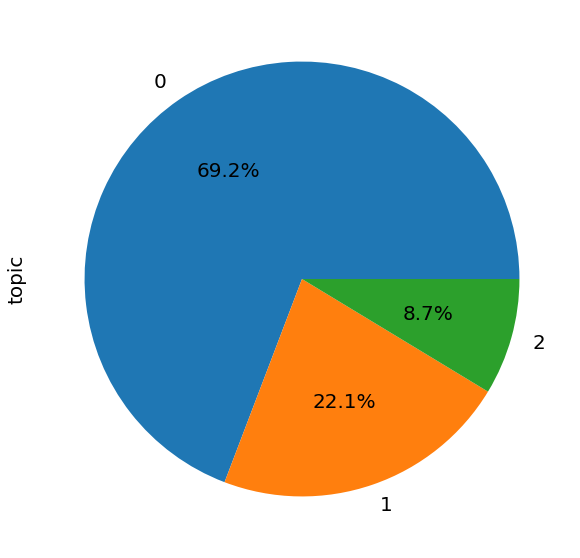

In [161]:
df_eng['topic'].value_counts().plot.pie(figsize=(10,10),autopct='%1.1f%%')

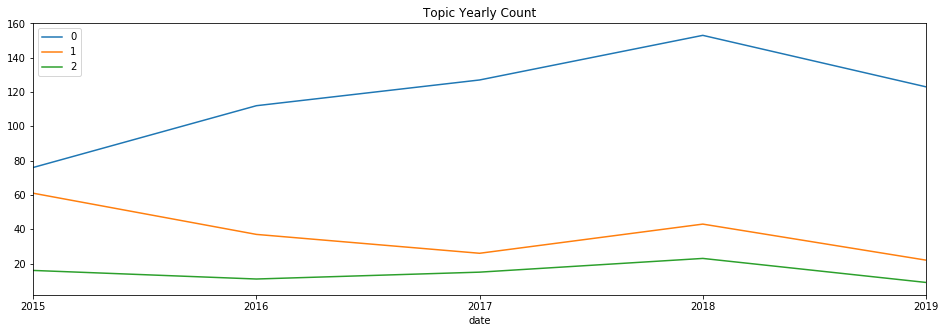

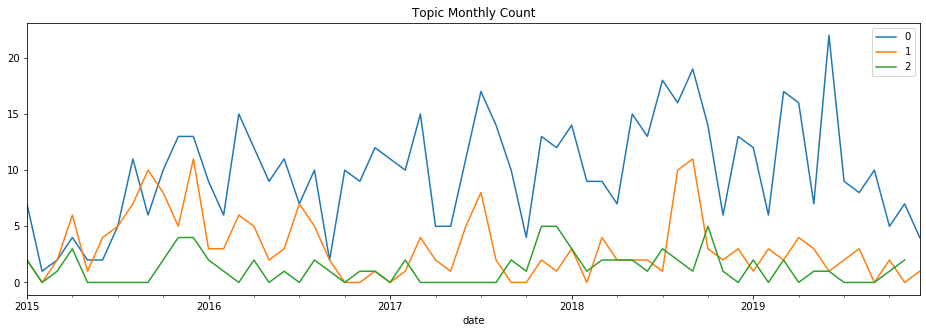

In [140]:
df_topic_year = pd.DataFrame()
df_topic_month = pd.DataFrame()
for topic in range(0,3,1):
    temp_df = df_eng[df_eng['topic'] == topic]
    temp_series = temp_df['topic']
    temp_series.index = temp_df['date']
    df_topic_year[topic] = temp_series.resample('Y').count()
    df_topic_month[topic] = temp_series.resample('M').count()
df_topic_year.plot(figsize=(16,5), title='Topic Yearly Count')
df_topic_month.plot(figsize=(16,5), title='Topic Monthly Count')

In [141]:
# Convert notebook to html
!jupyter nbconvert --to html_ch --output-dir='.\html' "3. Topic Modelling and Insights.ipynb"

[NbConvertApp] Converting notebook 3. Topic Modelling and Insights.ipynb to html_ch
[NbConvertApp] Writing 740409 bytes to .\html\3. Topic Modelling and Insights.html
